In [26]:
library(readxl)
library(minqa)

# Leer el archivo Excel
df <- read_excel("C:/Users/HP/Desktop/Desk/jupyter/database/pole.xls", col_names = FALSE)

# Extraer los datos de las columnas
valor1 <- df[[3]]
valor2 <- df[[4]]
x <- df[[1]]
y <- df[[2]]

New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`


In [27]:
distancia <- function(x1, y1, x2, y2) {
  return(sqrt((x1 - x2)^2 + (y1 - y2)^2))
}

distancias_al_punto <- function(x, y, j) {
  d <- matrix(NA, nrow = length(x), ncol = 2)
  N <- length(x)
  
  for (i in 1:N) {
    d[i, 1] <- distancia(x[j], y[j], x[i], y[i])
    d[i, 2] <- i
  }
  
  return(d)
}
dentro_fuera <- function(punto, r, X, Y) {
  dentro <- vector()
  fuera <- vector()
  N <- length(X)
  Distancia <- distancias_al_punto(X, Y, punto)
  
  for (i in 1:N) {
    if (Distancia[i, 1] <= r) {
      dentro <- c(dentro, Distancia[i, 2])
    } else {
      fuera <- c(fuera, Distancia[i, 2])
    }
  }
  
  return(list(dentro = dentro, fuera = fuera))
}
cov <- function(s_1x, s_1y, s_2x, s_2y, cx, cy, tao, a) {
  mini <- min((0.5 + distancia(s_1x, s_1y, cx, cy))^a, (0.5 + distancia(s_2x, s_2y, cx, cy))^a)
  return( exp(-tao * distancia(s_1x, s_1y, s_2x, s_2y) + mini))
}

matriz_cov <- function(x, y, cx, cy, tao, a) {
  n <- length(x)
  cov_1 <- matrix(NA, nrow = n, ncol = n)
  
  for (i in 1:n) {
    for (j in 1:n) {
      cov_1[i, j] <- cov(x[i], y[i], x[j], y[j], cx, cy, tao, a)
    }
  }
  
  return(cov_1)
}

Distri_Multivariada <- function(sigma, covarianza, x, mu)
{
  n <- length(x)
  mu <- as.matrix(mu)
  x <- as.matrix(x)
  
  # Calcular la descomposición espectral
  espectral <- eigen(covarianza)
  
  # Obtener los eigenvalores y eigenvectores
  eigenvalores <- espectral$values
  eigenvectores <- espectral$vectors 
  
  # Calcular el determinante a partir de los eigenvalores
  logdet <- sum(log(eigenvalores))
  
  inverza <- solve(covarianza)
  termino_cuadratico <- t(x - mu) %*% inverza %*% (x - mu)
  
  return( - 1/2 * (n*log(sigma**2)  +logdet) - 1/((sigma**2) *2) * termino_cuadratico)
}
Algoritmo_Medias <- function(valor){
  n <- length(valor)
  media <- mean(valor)
  MU <- rep(media, n)
  
  return (MU)
}

list_selec <- function(valor, puntos) {
  X <- vector()
  
  for (i in puntos) {
    X <- c(X, valor[i])
  }
  
  return(X)
}
L_Z_dentro <- function(punto, r, x, y, valor) {
  dentroFuera <- dentro_fuera(punto, r, x, y)
  dentro <- dentroFuera$dentro
  Valor_Dentro <- list_selec(valor, dentro)
  corx <- list_selec(x, dentro)
  cory <- list_selec(y, dentro)
  cx <- x[punto]
  cy <- y[punto]
  
  # mu <- Algoritmo_Medias(cx, cy, Valor_Dentro, corx, cory)
  mu <- Algoritmo_Medias(Valor_Dentro)
  f <- function(x_1) {
    t <- matriz_cov(corx, cory, cx, cy, x_1[2], x_1[3])
  
    if  (!is.na(det(t)) && det(t) > 0.001 ) {
      return(-Distri_Multivariada(x_1[1], t, Valor_Dentro, mu))
    } 
  }
  
  
  
  initial_guess <- c(1, 2, -1.5)
  result <- nlminb(initial_guess, lower=c(.0001, .0001,-3),f)

  
  return(list(-result$objective, result$par))
}

In [28]:
Circulos <- function( radio, num_puntos, x, y){
  circulos <- list()
  n <- length(x)
  k <- 0
  
  for(i in 1:n){
    q <- length(dentro_fuera( i, radio, x, y)$dentro)
    if ( num_puntos <= q ){
      k <- 1+ k
      circulos[[k]] <- i
    }
  }
  return (circulos)
}

In [29]:
L <- function(x, y, valor, radio) {
  Lo <- list()
  m <- 0
  a <- list(radio) 
  circulos <- Circulos( radio, 25, x, y)
  
  for (i in circulos) {
    for (j in a) {
      tryCatch({
        m <- m + 1
        parametros <- L_Z_dentro(i, j, x, y, valor)
        Lo[[m]] <- c(parametros[1], i, j, parametros[[2]][1],parametros[[2]][2],parametros[[2]][3])
      }, error = function(e) {
        #cat("Error en la iteración", m, ": ", conditionMessage(e), "\n")
      })
    }
  }
  return(Lo)
}

In [30]:
significancia<- function(numero_iteracion, valor2, x,y, estima){
    


    estadistico <- list()
    
    for(i in 1:numero_iteracion){
    
        conjunto_de_datos <- rnorm(length(valor2), mean=mean(valor2), sd=sd(valor2))
          
        # Mezclar el conjunto de datos
        conjunto_de_datos <- sample(conjunto_de_datos)
    
        suppressWarnings(lovero<-L(x, y, conjunto_de_datos,3))
    
        # Convertir la lista a un marco de datos
        mi_marco_datos <- do.call(rbind, lovero)
        mm   <-as.data.frame(mi_marco_datos)
        
        # Asignar nombres a las columnas
        colnames(mm) <- c("log ve", "punto", "radio", "sigma", "tao", "a")
        
        # Extraer los números de las listas y convertirlos en un vector numérico
         mm$`log ve` <- sapply( mm$`log ve`, function(x) x[[1]])
        
        # Ordenar el data frame por la columna "Edad"
        df_ordenado <- mm[order( mm$`log ve`), ]
        # Obtener el último elemento de la lista
        ultimo_elemento <- tail(df_ordenado, n = 1)
        estadistico[i] <-ultimo_elemento$`log ve`
    
        
                    }
                               
        # Convertir la lista a un vector
        mi_vector <- unlist(estadistico)
        hist(mi_vector, 
             main = "Histograma de Ejemplo", # Título del gráfico
             xlab = "Valores",               # Etiqueta del eje x
             ylab = "Frecuencia",            # Etiqueta del eje y
             col = "blue",                   # Color de las barras
             border = "black") 
        estadistico <- append(estadistico, estima[1,1]) 

    # Convertir la lista a un vector y ordenarla
    estadistico_ordenado <- sort(unlist(estadistico), decreasing = TRUE)
    
    orde<-length(estadistico_ordenado)
    for (i in 1:orde){
        if(estadistico_ordenado[i]==estima[1,1]){
            sig<- i/orde
        }
        
    }
    cat("La significancia es: ", sig)

}

,log ve,punto,radio,sigma,tao,a
,<dbl>,<list>,<list>,<list>,<list>,<list>
58,7.117831,112,3,0.5252196,0.3925532,-1.244346


La significancia es:  0.05

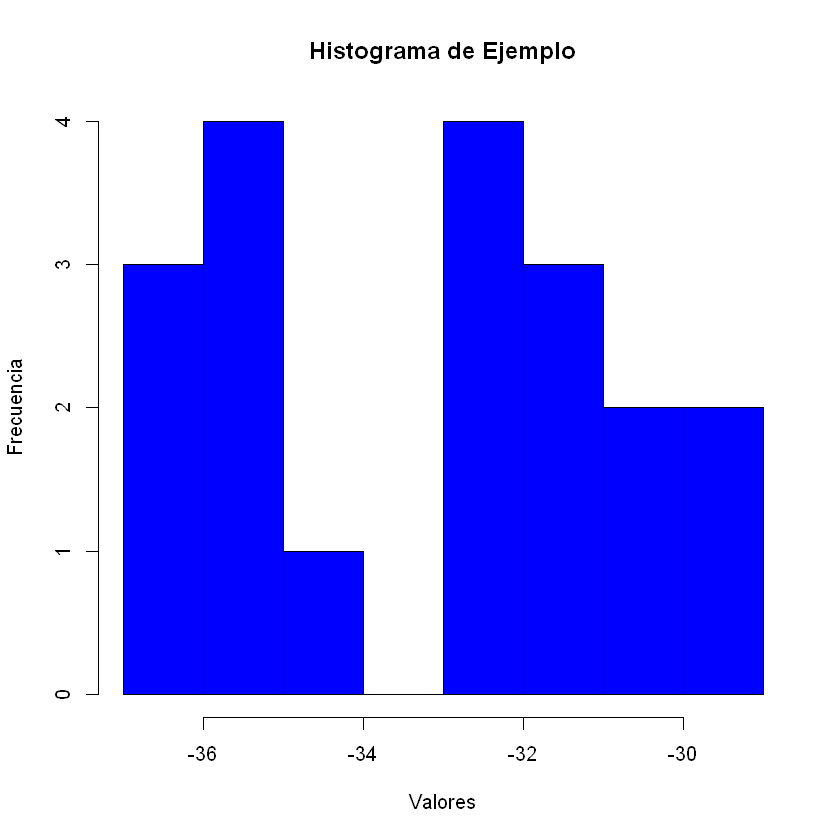

In [31]:
suppressWarnings(lovero<-L(x, y, valor2,3))


# Convertir la lista a un marco de datos
mi_marco_datos <- do.call(rbind, lovero)
mm   <-as.data.frame(mi_marco_datos)

# Asignar nombres a las columnas
colnames(mm) <- c("log ve", "punto", "radio", "sigma", "tao", "a")

# Extraer los números de las listas y convertirlos en un vector numérico
 mm$`log ve` <- sapply( mm$`log ve`, function(x) x[[1]])

# Ordenar el data frame por la columna "Edad"
df_ordenado <- mm[order( mm$`log ve`), ]
# Obtener el último elemento de la lista
ultimo_elemento <- tail(df_ordenado, n = 1)
ultimo_elemento

significancia(numero_iteracion=19, valor2, x,y, ultimo_elemento)

## A partir de los resultados obtenidos, podemos concluir que existe una fuente puntual, y el punto 112 es identificado como dicha fuente.